Created on Tue Apr 21 11:10:11 2020

@author: Deeps

In [1]:
import warnings
warnings.filterwarnings("ignore")
#!pip install torch
#!pip install torchsummary
#!pip install torchvision

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Displays a progress bar

import torch
from torch.utils import data
from torchsummary import summary
from torch import nn
from torch import optim
from PIL import Image
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import torch.nn.functional as F
from torchvision import datasets,models, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from data_gen import Dataset
from augment import Augmentations as aug
from visualization  import visualizer 

## Load the dataset and train, val, test splits

In [9]:
num_epochs = 50
num_classes = 2
batch_size = 5
num_rotations = 3 #180
rotations = [90,180,270]
learning_rate = 0.001
image_size = (748,500)
resnet_resize = (224,224)
datacsv = pd.read_csv("data.csv")
cv_results = []


### ------------Data Augmentation--------

Since we only have 119 images, and I want to keep the test set fixed at 20, with exactly 3 examples of class 0, I first split the data into 99 and 20. I then only apply augmentation to the 99 for training. I do not apply this augmentation function to the test data. only the transformations are applied.

In [10]:
all_ = len(datacsv['image'])
train_size = int(all_ *(5/6))
test_size = all_-train_size

traincsv = datacsv[:train_size]
testcsv = datacsv[train_size:]

In [11]:
data_base_aug = dict(traincsv)
data_base_aug["image"] = list(data_base_aug["image"])
data_base_aug["label"] = list(data_base_aug["label"])

if num_rotations>0:
    rot = aug(rotations)
    for k in range(len(data_base_aug["image"])):
        result = rot.rotate_append(data_base_aug["image"][k],data_base_aug["label"][k])
        traincsv = traincsv.append(result,ignore_index = True)

## --------------inspect--------------

Total Imagesl: 119
Train images: 396 , Test images: 20
Train Positives: 0.8888888888888888 , Test Positives: 0.85
Total positives: 0.8823529411764706


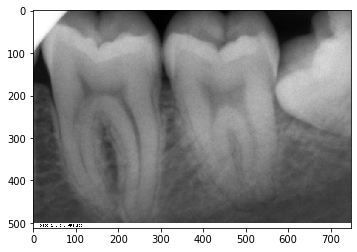

In [12]:
x_train = traincsv['image']
x_test = testcsv['image']
y_train = traincsv['label']
y_test = testcsv['label']

#x_train,x_test,y_train,y_test =tts(datacsv["image"], datacsv["label"],test_size=1/6, shuffle=False, random_state=42)
partition = {'train':list(x_train),'validation':list(x_test)}
labels = {}

combinedforlabels = traincsv.append(testcsv,ignore_index = True)

for k in range(len(combinedforlabels['image'])):
    labels['%s'%combinedforlabels['image'][k]] = combinedforlabels['label'][k]

print("Total Imagesl: %s"%all_)
print('Train images: %s'%(len(y_train)), ', Test images: %s'%(len(y_test)))
print('Train Positives: %s'%(np.sum(y_train)/len(y_train)), ', Test Positives: %s'%(np.sum(y_test)/len(y_test)))
print('Total positives: %s'%(np.sum(datacsv["label"])/len(datacsv["label"])))

view_image = Image.open('Dataset/' + str(int(datacsv["image"][10])) + '.jpg').convert('LA')
plt.imshow(view_image)

_____

In [ ]:
#print(x_train[:50])
#print(y_train[50])

# ----------Create dataset generator-------------

In [14]:
for cv in range(1):
    #x_train,x_test =tts(datacsv["image"],test_size=1/6, shuffle=False)
    
    #####################################################################
    
    training_set = Dataset(partition["train"],labels, image_size)
    training_generator = data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    
    validation_set = Dataset(partition['validation'], labels, image_size)
    validation_generator = data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
    
    
    #######################################################
    class Network(nn.Module):
        def __init__(self):
            super().__init__()
            self.resnet =  torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)
            self.num_ftrs = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(self.num_ftrs,16)
            self.fc1 = nn.Linear(16, num_classes)
            
        def forward(self,x):
            # TODO: Design your own network, implement forward pass here
            x = F.dropout(F.relu(self.resnet(x)),0.4)#3*748*512 -> 6*744*508 -> 6*372*254
            out = F.softmax(self.fc1(x))
            return out
    
    device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
    model = Network().to(device)
    
    ct = 0 
    model_size = len([1 for k in model.children()])
    print("model components: ", model_size)
    for child in model.children():
        ct+=1
        if ct==1:
            for param in child.parameters():
                param.requires_grad=False
    
    model.resnet.fc.weight.requires_grad = True
    model.resnet.fc.bias.requires_grad = True
    
    #model.resnet.layer4[0].conv1.weight.requires_grad = True
    #model.resnet.layer4[1].conv1.weight.requires_grad = True
    
    #model.resnet.layer4[0].conv2.weight.requires_grad = True
    model.resnet.layer4[1].conv2.weight.requires_grad = True
    
    model.fc1.weight.requires_grad = True
    model.fc1.bias.requires_grad = True
    
    summary(model,(3,resnet_resize[0],resnet_resize[1]))
    
    weights = torch.tensor([0.6,0.4])
    criterion = nn.CrossEntropyLoss(weight = weights) # Specify the loss layer
    optimizer = optim.Adam(model.parameters()) # Specify optimizer and assign trainable parameters to it, weight_decay is L2 regularization strength
       
    
    def train(model, training_generator, num_epoch = num_epochs): # Train the model
        print("Start training...")
        model.train() # Set the model to training mode
        for i in range(num_epoch):
            running_loss = []
            accuracy = []
            for batch, label in tqdm(training_generator):
                batch = batch.to(device)
                label = label.to(device)
                optimizer.zero_grad() # Clear gradients from the previous iteration
                pred = model(batch) # This will call Network.forward() that you implement
                loss = criterion(pred, label) # Calculate the loss
                running_loss.append(loss.item())
                correct = (torch.argmax(pred,dim=1)==label).sum().item()
                accuracy.append(correct/batch_size)
                loss.backward() # Backprop gradients to all tensors in the network
                optimizer.step() # Update trainable weights
            print("Epoch {} loss:{} accuracy:{}".format(i+1,np.mean(running_loss),np.mean(accuracy))) # Print the average loss for this epoch
            if (i+1)%5==0 or i==(num_epoch-1):
                try:
                    torch.save(model, "Trained_model/teeth_model_%s.pth"%(i+1))
                    print("Model saved at Trained _model")
                    print("Evaluate on validation set...")
                    evaluate(model, validation_generator)
                except:
                    print("Could not save model")
        print("Done!")

    
    def evaluate(model, validation_generator): # Evaluate accuracy on validation / test set
        model.eval() # Set the model to evaluation mode
        correct = 0
        total = 0
        with torch.set_grad_enabled(True): # Do not calculate grident to speed up computation
            for batch, label in tqdm(validation_generator):
                batch = batch.to(device)
                label = label.to(device)
                pred = model(batch)
                correct += (torch.argmax(pred,dim=1)==label).sum().item()
                total+=batch_size
        acc = correct/total
        print("Evaluation accuracy: {}".format(acc))
    
    def predict(model, validation_generator): # Evaluate accuracy on validation / test set
        model.eval() # Set the model to evaluation mode
        results = {'pred':[],'real':[]}
        with torch.set_grad_enabled(True): # Do not calculate grident to speed up computation
            for batch, label in tqdm(validation_generator):
                batch = batch.to(device)
                label = label.to(device)
                pred = model(batch)
                pred = torch.argmax(pred,dim=1)
                for k in range(len(pred)):
                    results['pred'].append(pred[k].item())
                    results['real'].append(label[k].item())
        return results

Using cache found in C:\Users\Deeps/.cache\torch\hub\pytorch_vision_master


model components:  2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-

## train and eval

In [ ]:
train(model, training_generator, num_epochs)

## Evaluation

In [ ]:
print("Evaluate on validation set...")
result = evaluate(model, validation_generator)
cv_results.append(result)

## See predictions

In [ ]:
#see_pred = pd.DataFrame(predict(model, validation_generator))
see_pred = pd.DataFrame(predict(model, validation_generator))

In [ ]:
print("Confusion matrix shows the TP, FP,TN, FN rates of the model")
print(confusion_matrix(see_pred['real'],see_pred['pred']))

In [ ]:

#vis.plot_filter(layer=model.resnet.conv1,single_channel = True)

In [ ]:
vis=visualizer()
vis.plot_filter(layer=model.resnet.layer4[0].conv1,single_channel = True)

In [ ]:
vis.plot_filter(layer=model.conv3,single_channel = True)

In [ ]:
vis.plot_filter(layer=model.conv4,single_channel = True)

In [ ]:
vis.plot_filter(layer=model.fc1,single_channel = False)